In [43]:
import numpy
import random as rand
import matplotlib.pyplot as plt
import math

## **Implementation of k-armed bandit problem**
Good exercise to see Exploration x Exploitation trade-off in practice.
This method uses the average action reward recieved to estimate the values of q*(a).
Solution for stationary bandit problems.

In [67]:
class k_armed_bandit:
    def __init__(self, k: int):
        self.k = k

    def simulate(
        self,
        steps: int = 1000,
        runs: float = 1000,
        epsilon: list | float = [0],
        actionvalue_est: str = "avg",
        actionselection_rule: str = "greedy",
        stationary: bool = True,
        a: float = 0,
        c: float = 0
    ) -> None:
        """
        Simulates a k-armed badit problem.

        epsilon-> Can be a scalar or list of numbers [0, 1].
        steps-> Number of steps of each run.
        runs-> Number of simulation runs.
        actionvalue_est-> Can hold the following values:
            "avg": uses the sample-average of rewards recieved to estimate a.v.
            "incremental": NEEDS STEPSIZE PARAMETER a TO BE SET, uses the incremental update rule to estimate a.v.
        actionselection_rule-> Can hold the following values:
            "greedy": uses greedy action selection method.
            "e-greedy": uses e-greedy action selection method, default epsilon value is set to 0.
            "ucb": NEEDS DEGREE OF EXPLORATION PARAMETER c TO BE SET, uses the upper-conficende-bound action selection method.
        stationary-> Problem to be simulated is stationary or nonstarionary. In case of False, every step will increment the qi* with a random value
                     generated from a normal distribution with mean qi* and standant deviation 0.01.
        a-> Stepsize parameter. Only used if actionvalue_est = "incremental".
        c-> Degrees of exploration parameter. Only used if actionselection_rule = "ucb".
        """

        #TREATING EPSILON TYPE
        try:
            iter(epsilon)
        except TypeError:
            epsilon = list(epsilon)

        self.epsilon = numpy.array(epsilon)
        self.steps = steps
        self.runs = runs
        self.opt_action_mean = numpy.array([numpy.zeros(steps) for _ in range(len(epsilon))])
        self.reward_mean = numpy.array([numpy.zeros(steps) for _ in range(len(epsilon))])
        self.estimates_mean = numpy.array([numpy.zeros(self.k) for _ in range(len(epsilon))])

        #ACTION VALUE ESTIMATE FUNCTION
        def av_estimate(q_est, q_count, new_reward):
            match actionvalue_est:
                case "avg":
                    return q_est + (new_reward - q_est)/(q_count) #CONVERGE
                
                case "incremental":
                    assert a <= 1 and a > 0, "Stepsize parameter needs to be inside interval (0, 1]"
                    return q_est + (a * (new_reward - q_est)) #DO NOT CONVERGE

        # CHOOSING ACTION
        def choose_action(q_estimates, q_counter, e_i, step):
            match actionselection_rule:
                case "greedy":
                    best_value = max(q_estimates)
                    best_actions = [i for i, q in enumerate(q_estimates) if q == best_value]
                    return rand.choice(best_actions)

                case "e-greedy":
                    if rand.random() < epsilon[e_i]: #EXPLORATORY ACTION TAKEN
                        return rand.randint(0,len(q_estimates)-1)

                    else: #GREEDY ACTION TAKEN
                        best_value = max(q_estimates)
                        best_actions = [i for i, q in enumerate(q_estimates) if q == best_value]
                        return rand.choice(best_actions)

                case "ucb":
                    assert c > 0, "Degrees of exploration needs to be greater than 0"
                    return numpy.argmax([q_estimates[action] + c*((math.log(step + 1)/q_counter[action])**0.5) if q_counter[action] > 0 else float('inf') for action in range(self.k)])
                    
        
        for e_i in range(len(epsilon)):
            for _ in range(runs):
                q_star = numpy.random.normal(0, 1, self.k) #REAL REWARDS
                q_estimates = [0 for _ in range(self.k)] #REWARDS ESTIMATES
                q_counter = [0 for _ in range(self.k)] # REWARD COUNTER
                opt_action = numpy.argmax(q_star)

                for step in range(steps):
                    action_chosen = choose_action(q_estimates, q_counter, e_i, step)

                    if action_chosen == opt_action: # MEAN COUNT OPTIMAL ACTION WAS CHOSEN AT GIVEN TIMESTEP
                        self.opt_action_mean[e_i][step] += 1/runs

                    if not stationary:
                        q_star += numpy.random.normal(0, 0.01, self.k)
                        opt_action = numpy.argmax(q_star)

                    reward = numpy.random.normal(q_star[action_chosen], 1, 1).item()

                    self.reward_mean[e_i][step] += reward/runs # MEAN REWARD AT GIVEN TIMESTEP

                    q_counter[action_chosen] += 1
                    q_estimates[action_chosen] = av_estimate(q_estimates[action_chosen], q_counter[action_chosen], reward, )

            for qi in range(self.k): #MEAN ESTIMATE REWARD VALUES
                self.estimates_mean[e_i][qi] += q_estimates[qi]/runs

In [68]:
kab = k_armed_bandit(10)

## Examples

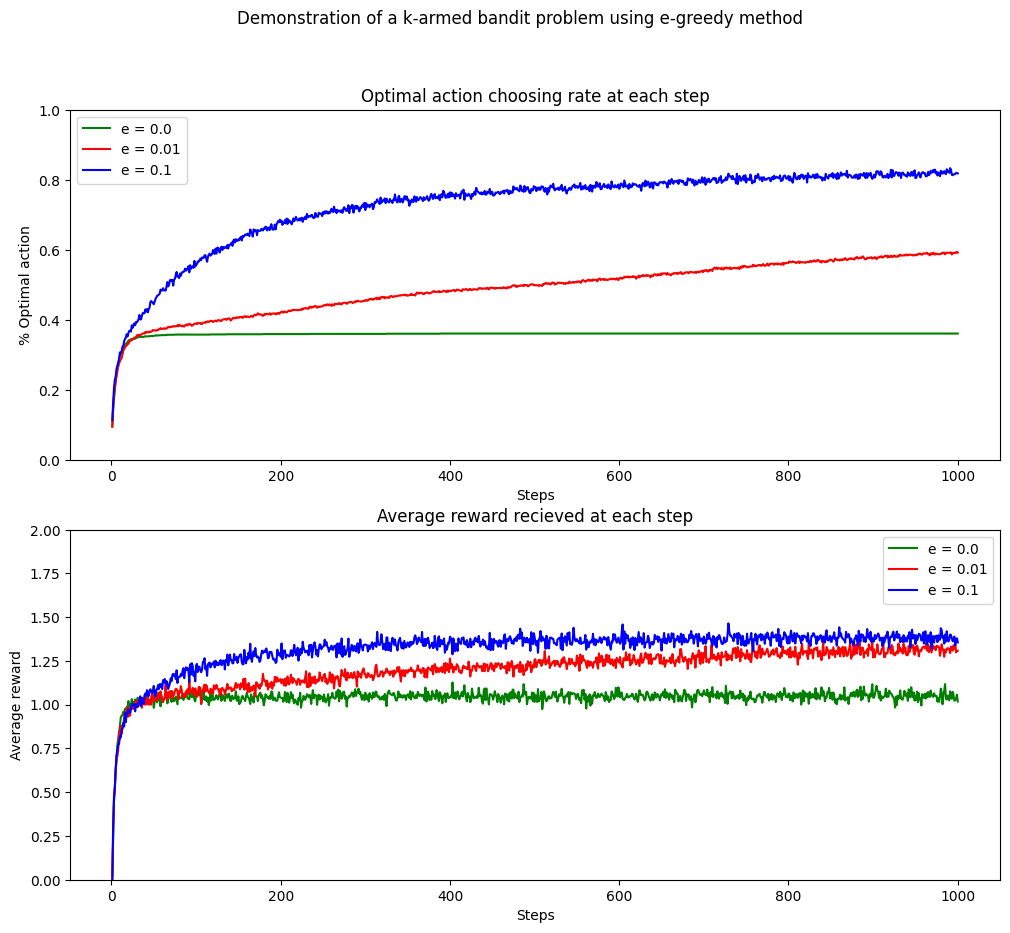

In [41]:
sim_params = {
    "steps":1000,
    "runs":2000,
    "epsilon":[0, 0.01, 0.1],
    "actionvalue_est":"avg",
    "actionselection_rule":"e-greedy"
}

kab.simulate(**sim_params)

fig, axs = plt.subplots(2, 1, figsize=(12,10))

colors = ['green', 'red', 'blue']

for e_i in range(len(kab.epsilon)):
    axs[0].plot(range(1, kab.steps + 1), kab.opt_action_mean[e_i], color=colors[e_i])
    axs[1].plot(range(1, kab.steps + 1), kab.reward_mean[e_i], color=colors[e_i])

fig.suptitle("Demonstration of a k-armed bandit problem using e-greedy method")

axs[0].set_ylim(0, 1)
axs[0].set_title('Optimal action choosing rate at each step')
axs[0].set_ylabel('% Optimal action')
axs[0].set_xlabel('Steps')
axs[0].legend([f'e = {kab.epsilon[i]}' for i in range(len(kab.epsilon))])

axs[1].set_ylim(0, 2)
axs[1].set_title('Average reward recieved at each step')
axs[1].set_ylabel('Average reward')
axs[1].set_xlabel('Steps')
axs[1].legend([f'e = {kab.epsilon[i]}' for i in range(len(kab.epsilon))])

plt.show()

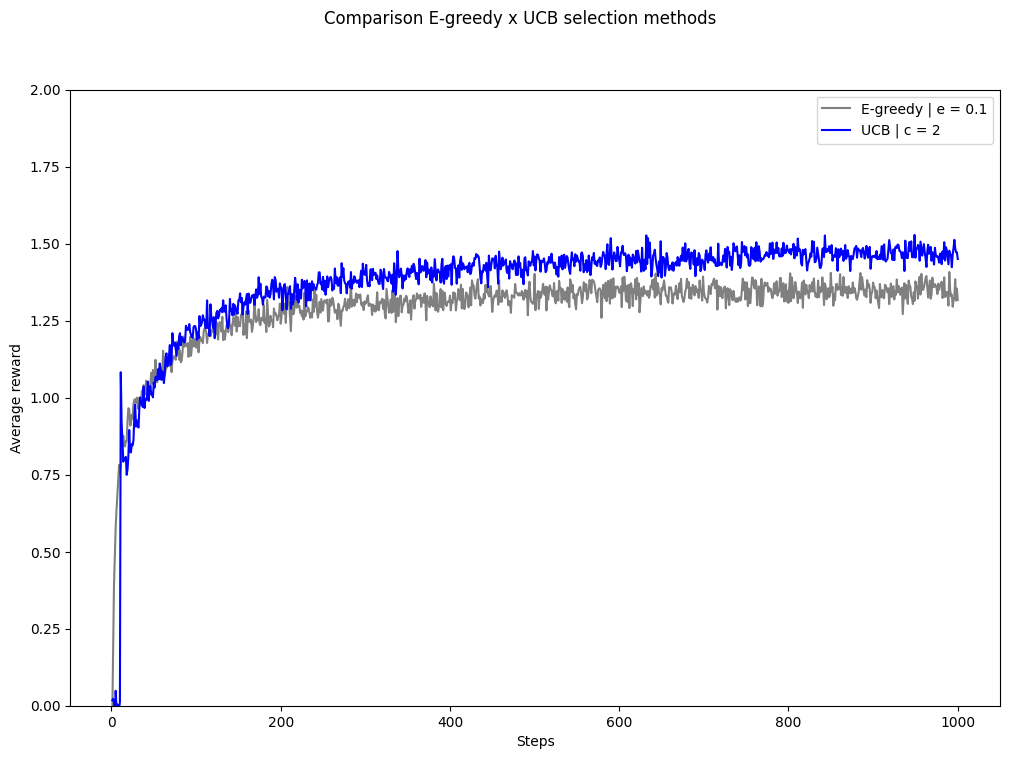

In [71]:
sim_params = {
    "steps":1000,
    "runs":2000,
    "epsilon":[0.1],
    "actionvalue_est":"avg",
    "actionselection_rule":"e-greedy"
}

#E-GREEDY AVERAGE REWARD WITH e = 0.1
kab.simulate(**sim_params)
egreedy_rewards = kab.reward_mean

#UCB AVERAGE REWARD WITH c = 2
sim_params["actionselection_rule"] = "ucb"
sim_params["c"] = 2

kab.simulate(**sim_params)
ucb_rewards = kab.reward_mean

fig, axs = plt.subplots(1, 1, figsize=(12,8))

fig.suptitle("Comparison E-greedy x UCB selection methods")

axs.plot(range(1, sim_params["steps"]+1), egreedy_rewards[0], color='grey')
axs.plot(range(1, sim_params["steps"]+1), ucb_rewards[0], color='blue')

axs.set_xlabel("Steps")
axs.set_ylabel("Average reward")
axs.set_ylim(0, 2)
axs.legend(['E-greedy | e = 0.1', 'UCB | c = 2'])

plt.show()
